In [1]:
%load_ext autotime

time: 135 µs (started: 2023-11-28 22:14:36 -05:00)


# Import Modules - AI574 Module is specific to this project

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" # Comment this out to run on GPU but CTC model may not save appropriately if trained on GPU
import tensorflow as tf
# tf.load_library("/etc/alternatives/libcudnn_so")
import re
import requests
import zipfile
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import random
random.seed(123)

import AI574Project
from AI574Project import *


2023-11-28 22:14:36.975188: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 22:14:36.975216: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 22:14:36.975241: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 22:14:36.981530: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 22:14:37.812532: W tensorflow/compiler/

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
time: 4.46 s (started: 2023-11-28 22:14:36 -05:00)


# Establish NER Capabilities

### Three methods are explored:
1) Statistical
2) Deep Learning - Leverages ConLL data
3) Industry Benchmark - Leverages SpACY module

1) Statistical

In [3]:
quote_indicator = AI574Project.QuotationIndicator()
StatisticalNameData = AI574Project.StatisticalNameData()

ssa_data_dir = './data/ssa_names'
unique_names_list, pronouns, person_titles = StatisticalNameData.create_common_name_dataset(ssa_data_dir)
unique_names_list = StatisticalNameData.append_known_names(AI574Project.hobbit_characters)

time: 1.58 s (started: 2023-11-28 22:14:41 -05:00)


2) Deep Learning

In [4]:
ner_data_importer = AI574Project.ImportNERData(source="existing") # use source = conll to update with conll data
train_dataset, val_dataset, lookup_layer = ner_data_importer.import_data()

Importing preloaded training and validation data
File /media/daniel/HDD1/AI574/Project/vocabulary.txt exists. Overwriting existing file.
time: 468 ms (started: 2023-11-28 22:14:42 -05:00)


In [5]:
train = "N"
if train == "Y":
    train_ner_model = TrainNERNamePrediction()
    train_ner_model.build_model()
    train_ner_model.compile_model()
    ner_history = train_ner_model.train(train_data=train_dataset,
                                val_data = val_dataset,
                                epochs=50, batch_size=256) 
    train_ner_model.save_model('NER_saved_recent')
    AI574Project.plot_training_charts(ner_history) 

time: 633 µs (started: 2023-11-28 22:14:43 -05:00)


In [6]:
ner_model = tf.keras.models.load_model('NER_saved_recent', custom_objects={'NERNonPaddingTokenLoss': NERNonPaddingTokenLoss})

time: 4.01 s (started: 2023-11-28 22:14:43 -05:00)


# Evaluate Performance of Competing NER Methods

In [7]:
def lowercase_and_convert_to_ids(tokens):
    tokens = tf.strings.lower(tokens)
    return lookup_layer(tokens)
def tokenize_and_convert_to_ids(text):
    tokens = text.split()
    return lowercase_and_convert_to_ids(tokens)
def string_prediction_w_spacy(text):
    text_nlp = nlp(text)
    ner_tagged = [word.ent_type_ for word in text_nlp]
    ner_tagged = [1 if word_type == "PERSON" else 0 for word_type in ner_tagged]
    return ner_tagged
def calculate_f1_score(combined_paired_list):
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    for pair in combined_paired_list:
        if pair == (1, 1):
            true_positives += 1
        elif pair == (1, 0):
            false_positives += 1
        elif pair == (0, 1):
            false_negatives += 1
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1_score

time: 805 µs (started: 2023-11-28 22:14:47 -05:00)


In [8]:
eval_ner = "N"
if eval_ner == "Y":
    conll_validation_file_path = "./data/val.txt"
    spacy_scored = []
    stat_scored = []
    dl_scored = []
    i = 0
    with open(conll_validation_file_path, 'r') as file:
        for line in file:
            i += 1
            line = line.split("\t")
            length = int(line[0])
            tags = line[length + 1 :]
            cleaned_tags = [int(item.strip()) for item in tags]
            string = line[1 : length + 1]

            spacy_prediction = string_prediction_w_spacy(' '.join(string))
            spacy_prediction_pair = list(zip(spacy_prediction, cleaned_tags))
            spacy_scored.append(spacy_prediction_pair)

            _, stat_prediction = StatisticalNameData.ner_process_line(string, is_list=True)
            stat_prediction = [int(item.strip()) for item in stat_prediction]
            stat_prediction_pair = list(zip(stat_prediction, cleaned_tags))
            stat_scored.append(stat_prediction_pair)

            dl_string_input = lowercase_and_convert_to_ids(string)
            dl_string_input = tf.reshape(dl_string_input, shape=[1, -1])
            dl_output = ner_model.predict(dl_string_input, verbose=0)
            dl_prediction = np.argmax(dl_output, axis=-1)[0]
            dl_prediction = [item - 1 for item in dl_prediction]
            dl_prediction_pair =  list(zip(dl_prediction, cleaned_tags))
            dl_scored.append(dl_prediction_pair)

        combined_spacy_list = [element for sublist in spacy_scored for element in sublist]
        combined_stat_list = [element for sublist in stat_scored for element in sublist]
        combined_dl_list = [element for sublist in dl_scored for element in sublist]

    spacy_f1_score = calculate_f1_score(combined_spacy_list)
    stat_f1_score = calculate_f1_score(combined_stat_list)
    deep_learning_f1_score = calculate_f1_score(combined_dl_list)
    
    print("Spacy NER F1 Scores: ",spacy_f1_score)
    print("Statistical SSA NER F1 Scores: ",stat_f1_score)
    print("Deep Learning conll F1 Scores: ",deep_learning_f1_score)    


time: 7.33 ms (started: 2023-11-28 22:14:47 -05:00)


# Establish CTC Capabilities

### Two methods are explored:
1) Statistical / Pseudo-random (ie. - recently mentioned character selected at random with forced narrator)
2) Deep Learning

In [9]:
CTCSetup = AI574Project.CTCSetup()

time: 2.99 ms (started: 2023-11-28 22:14:47 -05:00)


### Setting up the data environment

In [10]:
selected_works_path = './selected_works_for_ctc.csv'
line_chunk_size = 600
txt_all = ''
problem_files = []

orig_text = []
tokenized_text = []
quotation_indicators = [] 
mentions = [] 
mention_tokens = [] 
one_hot_mentions = [] 
speaker = [] 
name_to_token = []

with open(selected_works_path, mode='r', newline='') as file:
    csv_reader = csv.reader(file)
    for i, row in enumerate(csv_reader):
        if i % 500 == 1:
            print(i)
        target_path = os.path.join('./data/input_to_ctc',row[0]+'_input_to_ctc.txt')
        lines_as_strings = []
        CTCSetup.name_to_token = {} # reset name to token mapping for each book
        with open(target_path, mode='r', newline='') as file:
            lines = file.readlines()

        file_orig_text, file_tokenized_text, file_quotation_indicators, file_mentions, file_mention_tokens, file_one_hot_mentions, file_speaker, file_name_to_token = CTCSetup.process_text(data=lines[0])
        
        orig_text = orig_text + file_orig_text
        tokenized_text = tokenized_text + file_tokenized_text
        quotation_indicators = quotation_indicators + file_quotation_indicators
        mentions = mentions + file_mentions
        mention_tokens = mention_tokens + file_mention_tokens
        one_hot_mentions = one_hot_mentions + file_one_hot_mentions
        speaker = speaker + file_speaker
        name_to_token.append(file_name_to_token)

print(f"Processed {i} files with {len(problem_files)} errors.")

Processed 0 files with 0 errors.
time: 6.05 s (started: 2023-11-28 22:14:47 -05:00)


In [11]:
# Upload a scored dataset for CTC training using Chapter 1 of The Hobbit
scored_speaker = [name_to_token[0][name] for name in AI574Project.hobbit_chap1_scored if name in name_to_token[0]]
score_length = len(scored_speaker)
train_cutoff = int(score_length*0.75)
print(f"There are {score_length} total scored records and {train_cutoff} of them will be used for training leaving {score_length-train_cutoff} for validation")

There are 274 total scored records and 205 of them will be used for training leaving 69 for validation
time: 462 µs (started: 2023-11-28 22:14:53 -05:00)


In [12]:
random_speaker_zipped = list(zip(scored_speaker[train_cutoff-1:], speaker[train_cutoff:score_length], quotation_indicators[train_cutoff:score_length]))
filtered_random_speaker_zipped = [pred for pred in random_speaker_zipped if pred[2] != '0']
print(f"Pseudo-random F1 Score based on {len(filtered_random_speaker_zipped)} observations that were not marked as quotations")
filtered_scored_speaker, filtered_random_speaker, _ = zip(*filtered_random_speaker_zipped)

Pseudo-random F1 Score based on 42 observations that were not marked as quotations
time: 7.69 ms (started: 2023-11-28 22:14:53 -05:00)


In [13]:
weighted_f1 = f1_score(filtered_scored_speaker, filtered_random_speaker, average='weighted')
print("Pseudo-random weighted F1 score: ",weighted_f1)

Pseudo-random weighted F1 score:  0.4355514563548998
time: 6.28 ms (started: 2023-11-28 22:14:53 -05:00)


In [14]:
train_tokenized_text = np.array([x['input_ids'] for x in tokenized_text[:train_cutoff]])
train_mention_one_hot = one_hot_mentions[:train_cutoff]
train_array = np.concatenate([train_mention_one_hot, train_tokenized_text], axis=-1)
train_mention_tokens = [x['input_ids'] for x in mention_tokens[:train_cutoff]]
train_speaker = scored_speaker[:train_cutoff]

validate_tokenized_text = [x['input_ids'] for x in tokenized_text[train_cutoff:score_length]]
validate_mention_one_hot = one_hot_mentions[train_cutoff:score_length]
validate_array = np.concatenate([validate_mention_one_hot, validate_tokenized_text], axis=-1)
validate_mention_tokens = [x['input_ids'] for x in mention_tokens[train_cutoff:score_length]]
validate_speaker = scored_speaker[train_cutoff:score_length]

test_tokenized_text = [x['input_ids'] for x in tokenized_text[score_length:350]]
test_mention_one_hot = one_hot_mentions[score_length:350]
test_inputs = tf.constant(np.concatenate([test_mention_one_hot, test_tokenized_text], axis=-1), dtype=tf.float32)

test_mention_tokens = [x['input_ids'] for x in mention_tokens[score_length:]]


time: 14.9 ms (started: 2023-11-28 22:14:53 -05:00)


In [15]:
print(train_array.shape)
print(validate_array.shape)
print(test_inputs.shape)

(205, 562)
(69, 562)
(76, 562)
time: 266 µs (started: 2023-11-28 22:14:53 -05:00)


In [16]:
batch_size = 1

def map_record_to_training_data(features, labels):
    features_mapped = tf.constant(features, dtype=tf.float32)
    labels_mapped = tf.constant(labels, dtype=tf.float32)
    return features_mapped, labels_mapped

train_inputs, train_targets = map_record_to_training_data(train_array, train_speaker)
val_inputs, val_targets = map_record_to_training_data(validate_array, validate_speaker)

# Create datasets
train_dataset_inputs = tf.data.Dataset.from_tensor_slices(train_inputs)
train_dataset_targets = tf.data.Dataset.from_tensor_slices(train_targets)
val_dataset_inputs = tf.data.Dataset.from_tensor_slices(val_inputs)
val_dataset_targets = tf.data.Dataset.from_tensor_slices(val_targets)
test_dataset_inputs = tf.data.Dataset.from_tensor_slices(test_inputs).batch(batch_size)

# Combine input and target datasets
train_dataset = tf.data.Dataset.zip((train_dataset_inputs, train_dataset_targets)).batch(batch_size)
val_dataset = tf.data.Dataset.zip((val_dataset_inputs, val_dataset_targets)).batch(batch_size)

print(train_dataset)
print(val_dataset)
print(test_dataset_inputs)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 562), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 562), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=TensorSpec(shape=(None, 562), dtype=tf.float32, name=None)>
time: 8.65 ms (started: 2023-11-28 22:14:53 -05:00)


Epoch 1/8
205/205 [==============================] - 31s 133ms/step - loss: 2.4126 - accuracy: 0.4049 - val_loss: 1.7664 - val_accuracy: 0.3913
Epoch 2/8
205/205 [==============================] - 27s 129ms/step - loss: 1.7551 - accuracy: 0.4488 - val_loss: 1.6771 - val_accuracy: 0.3913
Epoch 3/8
205/205 [==============================] - 27s 131ms/step - loss: 1.6388 - accuracy: 0.4537 - val_loss: 1.6595 - val_accuracy: 0.3913
Epoch 4/8
205/205 [==============================] - 27s 134ms/step - loss: 1.5159 - accuracy: 0.4878 - val_loss: 1.6992 - val_accuracy: 0.4638
Epoch 5/8
205/205 [==============================] - 29s 141ms/step - loss: 1.3057 - accuracy: 0.5854 - val_loss: 1.7548 - val_accuracy: 0.3913
Epoch 6/8
205/205 [==============================] - 28s 138ms/step - loss: 1.2492 - accuracy: 0.5805 - val_loss: 1.7391 - val_accuracy: 0.3188
Epoch 7/8
205/205 [==============================] - 27s 134ms/step - loss: 1.2153 - accuracy: 0.6098 - val_loss: 1.7862 - val_accuracy:

INFO:tensorflow:Assets written to: CTC_saved_recent/assets


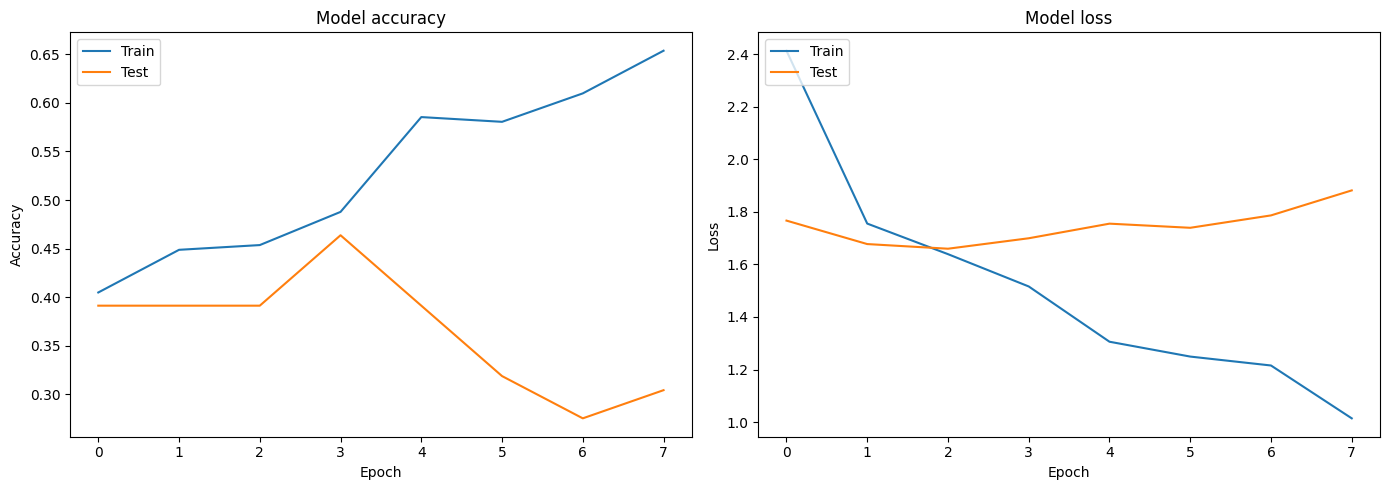

time: 3min 53s (started: 2023-11-28 22:14:53 -05:00)


In [17]:
train = 'Y'
if train == 'Y':
    
    TrainCTC = TrainCTCSpeakerPrediction(input_shape=train_array.shape[1])
    TrainCTC.build_model()
    TrainCTC.compile_model()
    ctc_history = TrainCTC.train(train_data=train_dataset,
                                val_data = val_dataset,
                                epochs=8, batch_size=1)
    TrainCTC.save_model('CTC_saved_recent')    

    AI574Project.plot_training_charts(ctc_history)

In [18]:
ctc_model = tf.keras.models.load_model('CTC_saved_recent')

time: 3.26 s (started: 2023-11-28 22:18:46 -05:00)


In [19]:
predictions = ctc_model.predict(val_dataset)

69/69 [==============================] - 1s 5ms/step
time: 694 ms (started: 2023-11-28 22:18:49 -05:00)


In [20]:
predicted_speakers = [next(speaker for speaker, token in name_to_token[0].items() if np.argmax(prediction) == token) for prediction in predictions]
predicted_speaker_tokens = [np.argmax(prediction) for prediction in predictions]


time: 2.43 ms (started: 2023-11-28 22:18:50 -05:00)


In [21]:
ctc_speaker_zipped = list(zip(scored_speaker[train_cutoff-1:], predicted_speaker_tokens, quotation_indicators[train_cutoff:score_length]))
filtered_ctc_speaker_zipped = [pred for pred in ctc_speaker_zipped if pred[2] != '0']
print(f"Deep Learning F1 Score based on {len(filtered_ctc_speaker_zipped)} observations")
filtered_scored_speaker, filtered_ctc_speaker, _ = zip(*filtered_ctc_speaker_zipped)

Deep Learning F1 Score based on 42 observations
time: 1.02 ms (started: 2023-11-28 22:18:50 -05:00)


In [22]:
weighted_f1 = f1_score(filtered_scored_speaker, filtered_ctc_speaker, average='weighted')
print("CTC weighted F1 score: ",weighted_f1)

CTC weighted F1 score:  0.20488625557749982
time: 5.72 ms (started: 2023-11-28 22:18:50 -05:00)


In [23]:
for text, predicted_speaker in zip(predicted_speakers, orig_text[train_cutoff:score_length]):
    print(f"{text}:\n{predicted_speaker}\n")

Narrator:
went on Gandalf,

Narrator:
I forgot to mention that with the map went a key, a small and curious key. Here it is!

Narrator:
he said, and handed to Thorin a key with a long barrel and intricate wards, made of silver.

Thorin:
Keep it safe!

Narrator:
Indeed | will,

Narrator:
said Thorin, and he fastened it upon a fine chain that hung about his neck and under his jacket.

Gandalf:
Now things begin to look more hopeful. This news alters them much for-the better. So far we have had no clear idea what to do. We thought of going East, as quiet and careful as we could, as far as the Long Lake. After that the trouble would begin.

Gandalf:
A long time before that, if | know anything about the loads East,

Gandalf:
interrupted Gandalf.

Narrator:
We might go from there up along the River Running,

Narrator:
went on Thorin taking no notice,

Narrator:
and so to the ruins of Dale-the old town in the valley there, under the shadow of the Mountain. But we none of us liked the idea of t